# Analysis of the effect of ethnicity on food purchase in London

- Does ethnic diversity have an effect on food purchase at area level? And if yes, what is its nature?
- To which extent is the ethnic diversity responsible for the food purchase diversity of some aliment categories?
- Can we attribute particular food purchase habits to specific ethnic groups?

The objective is to extend the Tesco dataset with a dataset containing numerous interesting socio-economic statistics in the London area. The analysis focuses on LSOA regions, which is the finest resolution available in the Tesco dataset. The proportion of inhabitants from various ethnicities is given for each LSOA in the additional dataset. We will first analyze the effect of ethnic diversity on food purchase. It will be based on the comparison of diversity of food categories purchased across LSOA regions and their ethnic diversity. We will then try to validate the observations we made by assessing if they still hold when other socio-economic aspects (such as mean wage for example) are taken into account. Depending on the results found, we will also investigate in greater details what impact specific ethnic populations may have on the food purchase.

## Table of content 

## 1. Set the environment and perform exploratory analysis

### Import the packages 

In [1]:
### Classic imports 

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib

import os


### Imports for statistical analysis

import scipy
from scipy.stats import spearmanr

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split


### Imports for specific visualizations

import geopandas as gpd

import plotly
import plotly.express as px
import plotly.graph_objects as go


### Import associated to propensity score matching

from causal_curve import GPS


### Other imports

import re


### Define the paths of the different datasets use for the analysis
Three main datasets are used for this project:
- **Tesco dataset**: besides the nutrients information used in the validation analysis of the paper, this dataset offers information on the purchases of different products at the area level. It's those information that will be used in our project at the LSOA level. 
- **Socio-economic dataset of the LSOA**: this dataset provides socio-economic information at the LSOA level. Combining this dataset with the Tesco one will allow us to put into perspective the ethnicity of the population with their food consumption. 
- **Geographical information dataset of the LSOA**: this dataset will be used for visualization purposes as it will allow to display some of the results on the London map with relevant values assigned to each geographical region representing the LSOA. 

In [2]:
GEO_LSOA_PATH = os.getcwd() + '/data/Geo_data/LSOA_2011_London_gen_MHW.shp'
TESCO_PATH = os.getcwd() + '/data/Area_level_data/year_lsoa_grocery.csv'
SOCIO_ECO_LSOA_PATH = os.getcwd() + '/data/lsoa-data.csv'

### Define some functions that will be used throughout the project
The roles of the functions define below are the following:
- `load_merge_clean_data()`: this function takes as input the paths of the three datasets used in this project. It will load those different datasets and process them to return one single dataset containing the information of the three datasets of interest.
- `plot_map()`: this function allows to display a feature on the London map with its values assigned to each geographical region representing the LSOA. It takes as input the dataframe considered (that should contain the geographical information) as well as the name of the feature to be plotted on the map, if this feature is part of the dataframe, OR the feature array can directly be given as an input as well. 

In [3]:
###############################################################################################################
#############################     Load merge and clean function      ##########################################
###############################################################################################################
def filter_and_clean_losa(lsoa_df):
    
    filtered_df = lsoa_df.copy()
    
    ##### REPLACE UNKNOWN VALUES #####
    filtered_df.replace('-', np.NaN, inplace=True)
    filtered_df.replace('.', np.NaN, inplace=True)

    ##### DROP ALL IRRELEVANT COLUMNS #####
    # Mid-year Population Estimates (already in tesco data)
    # Census Population (already in tesco data)
    # Population Density (already in tesco data)
    # Road casualties (irrelevant)
    to_remove = ['Mid-year Population Estimates',
                 'Census Population',
                 'Population Density',
                 'BAME',
                 'Economically active: Total',
                 'Economically inactive: Total',
                 'Road Casualties']
    to_drop = []
    for col in filtered_df.columns:
        for sub in to_remove:
            if(sub in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS NOT RELATED TO 2011 #####
    to_drop = []
    for col in filtered_df.columns:
        nums = re.findall('[0-9]+', col)
        for num in nums:
            if(len(num) == 4 and num != '2011'):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS THAT ARE ABSOLUTE VALUE IF THERE IS PROPORTIONS FOR SAME DATA #####
    to_drop = []
    begin_with = ['Household Composition',
                  'Ethnic Group',
                  'Country of Birth',
                  'Household Language',
                  'Religion',
                  'Tenure',
                  'Dwelling type',
                  'Qualifications',
                  'Health',
                  'Car or van availability',
                  'Adults in Employment',
                  'Lone Parents']
    for col in filtered_df.columns:
        for sub in begin_with:
            if(col.startswith(sub) and '%' not in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### TRANSFORM ALL PERCENTAGES VALUES IN RATIO BETWEEN 0 AND 1 #####
    for col in filtered_df.columns:
        if('%' in col):
            # convert to numerical value
            filtered_df[col] = pd.to_numeric(filtered_df[col])
            # transform percentage in ratio
            filtered_df[col] /= 100
            # rename the column
            new_name = col.replace("%", "ratio")
            filtered_df.rename(columns = {col: new_name}, inplace = True) 
    
    return filtered_df


def load_merge_clean_data(TESCO_PATH, SOCIO_ECO_LSOA_PATH, GEO_LSOA_PATH):
    '''
    This function load the different datasets used for the analysis,
    clean and merge those datasets together to obtain as an output one single panda dataframe
    with the socio-economic, the Tesco and the geography information of each LSOA
    '''
    # load the data with the geography information of each LSOA
    map_df = gpd.read_file(GEO_LSOA_PATH)
    # set the index of this dataframe to the code of each LSOA to facilitate the merge of the dataframes
    map_df.index = map_df['LSOA11CD']
    
    # load the data with the Tesco information of each LSOA
    data_df = pd.read_csv(TESCO_PATH)
    
    # merge the Tesco dataframe with the one with the geo information of the corresponding regions  
    merged_map_df = map_df.join(data_df.set_index('area_id'))
    
    # convert coordinates that are in UTM format into latitude longitude (to plot the results on a map)
    merged_map_df = merged_map_df.to_crs({'init': 'epsg:4326'}) # cause of the warning
    
    # load the data with the socio-economic information of each LSOA
    lsoa_df = pd.read_csv(SOCIO_ECO_LSOA_PATH, encoding = "ISO-8859-1", engine='python')
    # drop the last 2 rows that are full of nan (due to the format of the title of the columns (3 rows))
    lsoa_df.drop(lsoa_df.tail(2).index,inplace=True)
    # filter the lsoa dataset
    lsoa_df = filter_and_clean_losa(lsoa_df)
    
    # merge the merged dataframe with  the socio-economic dataframe of the corresponding regions  
    merged_map_lsoa_df = merged_map_df.join(lsoa_df.set_index('Lower Super Output Area'))
    
    # set the index of this dataframe to the name of each LSOA to obtain more comprehensive data
    merged_map_lsoa_df.index = merged_map_lsoa_df['LSOA11NM']
    
    # remove the rows for which we don't have data everywhere 
    # consider the feature of population to determine where we lack some information
    population = np.array((merged_map_lsoa_df['population'])) 
    merged_map_lsoa_df = merged_map_lsoa_df[np.logical_not(np.isnan(population))]
    
    # remove spaces in column names
    merged_map_lsoa_df.columns = merged_map_lsoa_df.columns.str.replace(' ', '_')
    
    # return this final merged and cleaned dataset
    return merged_map_lsoa_df


###############################################################################################################
#####################################     Plot functions     ##################################################
###############################################################################################################

def plot_map(dataframe, name_feature, color = 'magma', opacity = 0.9):
    '''
    plot the feature of the dataframe on the London map
    '''
    fig = px.choropleth_mapbox(dataframe,
                               geojson=dataframe.geometry,
                               locations=dataframe.index,
                               color=name_feature,
                               center={"lat": 51.49, "lon": -0.127},
                               mapbox_style="carto-positron",
                               opacity = opacity,
                               color_continuous_scale = color, # https://plotly.com/python/colorscales/   
                               # magma, viridis
                               zoom=9)

    fig.update_layout(height = 500, margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

### Create the dataframe with all the information of the three datasets of interest

In [4]:
full_df = load_merge_clean_data(TESCO_PATH, SOCIO_ECO_LSOA_PATH, GEO_LSOA_PATH)
full_df.head(5)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Health;Very_good_or_Good_health_(ratio);2011,Health;Fair_health_(ratio);2011,Health;Bad_or_Very_Bad_health_(ratio);2011,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
City of London 001A,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,0.886,0.094,0.020,0.592,0.325,0.061,0.017,0.005,74846.0,58347.0
City of London 001B,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,0.899,0.074,0.027,0.580,0.353,0.046,0.016,0.006,73325.0,57159.0
City of London 001C,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,0.807,0.132,0.062,0.802,0.181,0.013,0.002,0.001,44130.0,34387.0
City of London 001E,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,0.794,0.133,0.073,0.762,0.214,0.019,0.004,0.000,30781.0,24000.0
Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,0.861,0.097,0.042,0.343,0.459,0.160,0.026,0.013,46141.0,39141.0


## Computation of new features

In [5]:
def compute_entropies(df, f_col_list):
    
    f_df = df[f_col_list]
    n_col = len(f_col_list)
        
    h_df = pd.DataFrame()
    
    if np.any(f_df > 1):
        f_df = f_df.div(f_df.sum(axis=1), axis=0)
        
    # compute intermediates values inside the sum of eq (12)
    for col in f_df.columns:
        col_val = f_df[col] * np.log2(f_df[col])
        h_df.insert(len(h_df.columns), col, col_val, True)

    # compute the entropy as the sum of the intermediates values
    h = - h_df.sum(axis=1)
    h_df.insert(0, 'h', h, True)

    # remove all the intermediate values from the dataframe
    h_df = h_df.iloc[:, :1]

    # normalization
    h_df['h_norm'] = h_df['h'] / np.log2(n_col)
    
    return h_df['h'].values, h_df['h_norm'].values

To make a difference between food and drinks, in addition to the already present h_items, we compute two new category entropies taking only part of the items in consideration h_food and h_drink with their normalizer conterparts

In [6]:
food_col_list = ['f_dairy',
                 'f_eggs',
                 'f_fats_oils',
                 'f_fish',
                 'f_fruit_veg',
                 'f_grains',
                 'f_meat_red',
                 'f_poultry',
                 'f_readymade',
                 'f_sauces',
                 'f_sweets']

h_items_food, h_items_food_norm = compute_entropies(full_df, food_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('h_items') 
full_df.insert(new_h_idx, 'h_items_food_norm', h_items_food_norm.tolist(), True)
full_df.insert(new_h_idx, 'h_items_food', h_items_food.tolist(), True)

In [7]:
drink_col_list = ['f_beer',
                  'f_soft_drinks',
                  'f_spirits',
                  'f_tea_coffee',
                  'f_water',
                  'f_wine']

h_items_drink, h_items_drink_norm = compute_entropies(full_df, drink_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('h_items') 
full_df.insert(new_h_idx, 'h_items_drink_norm', h_items_drink_norm.tolist(), True)
full_df.insert(new_h_idx, 'h_items_drink', h_items_drink.tolist(), True)

We then compute an entropy of the diverse ethnic groups in each area to get a sense of the racial diversity of the area

For our entropy computation, we need the representation of each ethnic groups to be described as a probability between 0 and 1 instead of a percentage value, we will modify those columns accordingly in the dataframe

In [8]:
ethnicity_col_list = ['Ethnic_Group;White_(ratio);2011',
                      'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
                      'Ethnic_Group;Asian/Asian_British_(ratio);2011',
                      'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
                      'Ethnic_Group;Other_ethnic_group_(ratio);2011']

h_ethnicity, h_ethnicity_norm = compute_entropies(full_df, ethnicity_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('Country_of_Birth;ratio_United_Kingdom;2011') 
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities_norm;2011', h_ethnicity_norm.tolist(), True)
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities;2011', h_ethnicity.tolist(), True)

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 2. Exploration of the dataset

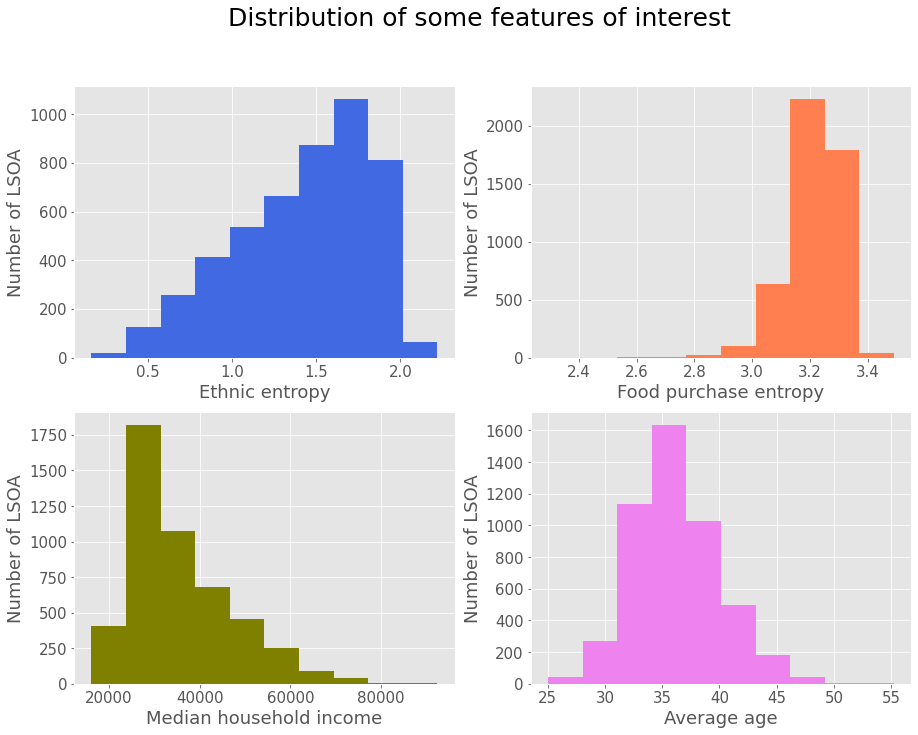

In [9]:
style.use('ggplot')

fig, ax = plt.subplots(2,2,figsize=(15,11))

plt.suptitle("Distribution of some features of interest", fontsize=25)

ax[0,0].hist(full_df['Ethnic_Group;h_ethnicities;2011'], color='royalblue')
ax[0,0].set_xlabel('Ethnic entropy', fontsize=18)
ax[0,0].set_ylabel('Number of LSOA', fontsize=18)
ax[0,0].tick_params(labelsize=15)

ax[0,1].hist(full_df['h_items'], color='coral')
ax[0,1].set_xlabel('Food purchase entropy', fontsize=18)
ax[0,1].set_ylabel('Number of LSOA', fontsize=18)
ax[0,1].tick_params(labelsize=15)

ax[1,0].hist(full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)'], color='olive')
ax[1,0].set_xlabel('Median household income', fontsize=18)
ax[1,0].set_ylabel('Number of LSOA', fontsize=18)
ax[1,0].tick_params(labelsize=15)

ax[1,1].hist(full_df['avg_age'], color='violet')
ax[1,1].set_xlabel('Average age', fontsize=18)
ax[1,1].set_ylabel('Number of LSOA', fontsize=18)
ax[1,1].tick_params(labelsize=15)

plt.show()

By looking at some of the main features in our dataset we see multiple interesting things. For example, the food purchase entropy does not seem like it varies a lot from an LSOA to another. As a lot of items are sold in Tesco, it is clear that the diversity in food purchase is high in general. In comparison, the median household income or the average age have a high variance from one LSOA to another, because the population can be completely different between areas. Think about an area in the center of London, compared to one in its suburbs. As housing prices are higher in the center, people that can afford such flats/houses tend to earn more money. Now if we come back to food purchase diversity: it is clear that, even if some people purchase a larger variation of items than other, these differences are small compared to the ones of other metrics. It is easy to find a Londoner earning 10x more money as another Londoner, but the same thing cannot be said for food purchase diversity. Therefore, food purchase diversity inherently has less variance than the other features presented here and it does not mean that differences in this feature cannot be meaningful.
Ethnic entropy has a lot of variance, with some areas very diverse in terms of ethnicities represented, while others are more conservative.

## 3. Correlation analysis

To begin our analysis, we compute the correlations between the ethnicity and the product categories purchased at different level of granularity. We used Spearman rank correlation.

- Correlation between h_ethnicity_norm and h_food_norm, h_drink_norm
- Correlation between the different proportions of ethnic groups and h_food_norm, h_drink_norm
- Correlation between the different propotrions of ethnic groups and different propotrions of items category

### Correlation between h_ethnicity_norm and h_food_norm, h_drink_norm

In [10]:
h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011'].values
h_items = full_df['h_items_norm'].values
h_items_food = full_df['h_items_food_norm'].values
h_items_drink = full_df['h_items_drink_norm'].values

rho_items, p_items = spearmanr(h_ethnicity, h_items)
rho_food, p_food = spearmanr(h_ethnicity, h_items_food)
rho_drink, p_drinks = spearmanr(h_ethnicity, h_items_drink)


d = {'Category': ['items','food', 'drink'],
     'R': [rho_items, rho_food, rho_drink],
     'p-value': [p_items, p_food, p_drinks]}
hh_corr_df = pd.DataFrame(data=d)
hh_corr_df

,Category,R,p-value
0,items,0.368818,1.285898e-155
1,food,0.286189,9.082810e-92
2,drink,0.192731,1.157947e-41


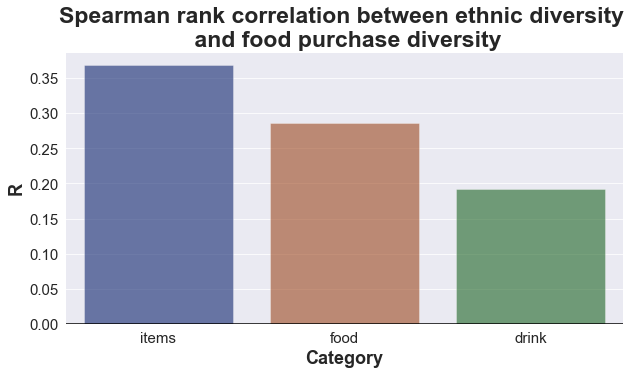

In [11]:
# keep only the significant data
# Bonferroni adjusted alpha
n_test = 3
alpha_adj = 0.05/n_test

hh_plot_df = hh_corr_df[hh_corr_df['p-value'] < alpha_adj]

sns.set_style("dark")

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Category', y='R', data=hh_plot_df, palette='dark', alpha=.6)
ax.grid(axis='y')
ax.set_ylabel('R', fontsize=18, fontweight='bold')
ax.set_xlabel('Category', fontsize=18, fontweight='bold')

#plt.xticks(rotation=90 )
ax.axhline(y=0, color='k', linestyle='-')
ax.set_title('Spearman rank correlation between ethnic diversity \n and food purchase diversity',
             fontsize=23, fontweight='bold')
ax.tick_params(labelsize=15)
plt.show()

### Correlation between the different proportions of ethnic groups and h_food_norm, h_drink_norm

In [12]:
f_ethnicity_idx_lo = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011')
f_ethnicity_idx_hi = full_df.columns.get_loc('Ethnic_Group;Other_ethnic_group_(ratio);2011')+1

# list containing the name of the ethnic groups
ethnicity_col = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) 
ethnic_col_short = np.array(['White', 'Mixed', 'Asian', 'Black', 'Other ethnicities'])

n_ethnicity = ethnicity_col.shape[0]

# list containing the name of the item categories (food or drink)
category_col = np.array(['items',
                         'food',
                         'drink'])
n_category = category_col.shape[0]

# repeat elements to have same length and suitable format
ethnicity_col = np.repeat(ethnicity_col, n_category)
ethnic_col_short = np.repeat(ethnic_col_short, n_category)
category_col = np.tile(category_col, n_ethnicity)

# list containing the values of the ethnic group representations
f_ethnicities = []
for col in full_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(full_df[col].values)

# list containing the values of items entropy for food and drink
h_items = full_df['h_items_norm'].values
h_items_food = full_df['h_items_food_norm'].values
h_items_drink = full_df['h_items_drink_norm'].values
h_item_categories = [h_items, h_items_food, h_items_drink]

# compute the correlation and their p-values
R_col = []
p_col = []
for et in f_ethnicities:
    for cat in h_item_categories:
        R, p = spearmanr(et, cat)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnicity': ethnic_col_short.tolist(),
     'Category': category_col.tolist(),
     'R': R_col,
     'p-value': p_col}

fh_corr_df = pd.DataFrame(data = d)
fh_corr_df

,Ethnicity,Category,R,p-value
0,White,items,-0.236992,1.109595e-62
1,White,food,-0.148771,2.537757e-25
2,White,drink,-0.155952,1.082312e-27
3,Mixed,items,0.441581,7.456270e-230
4,Mixed,food,0.310607,1.375516e-108
5,Mixed,drink,0.249160,2.676778e-69
6,Asian,items,-0.114748,1.227568e-15
7,Asian,food,-0.053519,1.974140e-04
8,Asian,drink,-0.078691,4.310637e-08
9,Black,items,0.572196,0.000000e+00


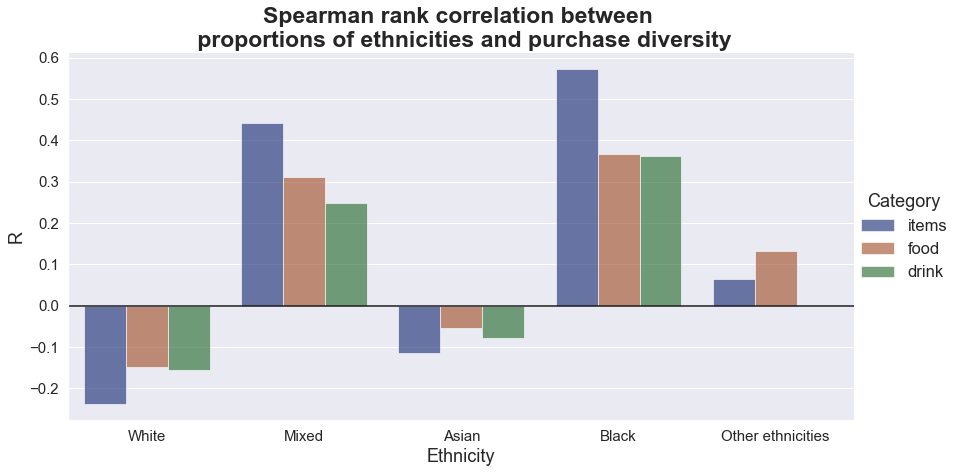

In [13]:
# keep only the significant data 
# Bonferroni adjusted alpha
n_test = 15
alpha_adj = 0.05/n_test

fh_plot_df = fh_corr_df[fh_corr_df['p-value'] < alpha_adj]

sns.set_style("dark")
sns.set(font_scale=1.5)

g = sns.catplot(data=fh_plot_df, kind="bar", x="Ethnicity", y="R", hue="Category", palette="dark", 
                alpha=.6, height=6, aspect=2)

for ax in g.axes.flat:
    ax.grid(True, axis='y')
ax.axhline(y=0, color='k')

#plt.xticks(rotation=45 )

ax.tick_params(labelsize=15)

ax.set_title('Spearman rank correlation between \n proportions of ethnicities and purchase diversity',
             fontsize=23, fontweight='bold')

plt.show()

### Correlation between the different proportions of ethnic groups and different proportions of items category

In [14]:
# list containing names of the different products proportions
f_items_idx_lo = full_df.columns.get_loc('f_beer') 
f_items_idx_hi = full_df.columns.get_loc('f_wine')+1
item_col = np.array(full_df.columns[f_items_idx_lo:f_items_idx_hi]) # list containing name of the columns
n_item = item_col.shape[0]

# list containing names of the different ethnic groups
f_ethnicity_idx_lo = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011')
f_ethnicity_idx_hi = full_df.columns.get_loc('Ethnic_Group;Other_ethnic_group_(ratio);2011')+1
ethnicity_col = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) # list containing name of the columns
ethnicity_col_short = np.array(['White', 'Mixed', 'Asian', 'Black', 'Other ethnicities'])
n_ethnicity = ethnicity_col.shape[0]

# repeat elements to get good format
item_col = np.tile(item_col, n_ethnicity)
ethnicity_col = np.repeat(ethnicity_col, n_item)
ethnicity_col_short = np.repeat(ethnicity_col_short, n_item)


f_items = []
for col in full_df.iloc[:, f_items_idx_lo:f_items_idx_hi].columns:
    f_items.append(full_df[col].values)

f_ethnicities = []
for col in full_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(full_df[col].values)
    
R_col = []
p_col = []

for et in f_ethnicities:
    for item in f_items:
        R, p = spearmanr(et, item)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnicity': ethnicity_col.tolist(),
     'Item': item_col.tolist(),
     'R': R_col,
     'p-value': p_col}
      
ff_corr_df = pd.DataFrame(data = d)

# add a "Category column" to label items as food or drink
def is_food_or_drink(Item):
    
    food_list = set(['f_dairy',
                     'f_eggs',
                     'f_fats_oils',
                     'f_fish',
                     'f_fruit_veg',
                     'f_grains',
                     'f_meat_red',
                     'f_poultry',
                     'f_readymade',
                     'f_sauces',
                     'f_sweets'])

    drink_list = set(['f_beer',
                      'f_soft_drinks',
                      'f_spirits',
                      'f_tea_coffee',
                      'f_water',
                      'f_wine'])
    
    if Item in food_list :
        return "food"
    elif Item in drink_list :
        return "drink"

ff_corr_df.insert(1, 'Category', ff_corr_df['Item'].apply(is_food_or_drink), True)
ff_corr_df

,Ethnicity,Category,Item,R,p-value
0,Ethnic_Group;White_(ratio);2011,drink,f_beer,0.205189,4.187796e-47
1,Ethnic_Group;White_(ratio);2011,food,f_dairy,-0.273152,1.895280e-83
2,Ethnic_Group;White_(ratio);2011,food,f_eggs,-0.309786,5.383464e-108
3,Ethnic_Group;White_(ratio);2011,food,f_fats_oils,-0.426744,3.490461e-213
4,Ethnic_Group;White_(ratio);2011,food,f_fish,-0.013208,3.586075e-01
...,...,...,...,...,...
80,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_spirits,0.098075,8.323222e-12
81,Ethnic_Group;Other_ethnic_group_(ratio);2011,food,f_sweets,-0.239118,8.226865e-64
82,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_tea_coffee,0.110457,1.354980e-14
83,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_water,0.189520,2.553798e-40


<ipython-input-15-755cee404461>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['R'][plot_df['p-value'] >= alpha_adj] = 0


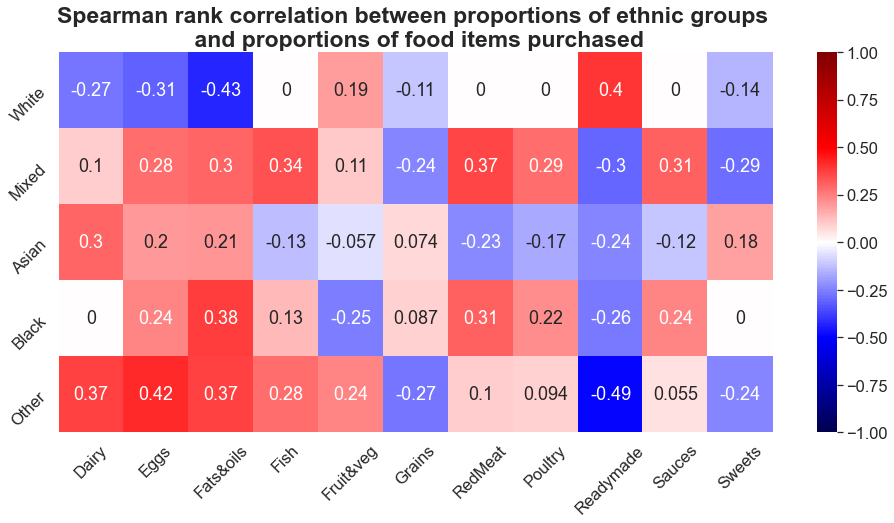

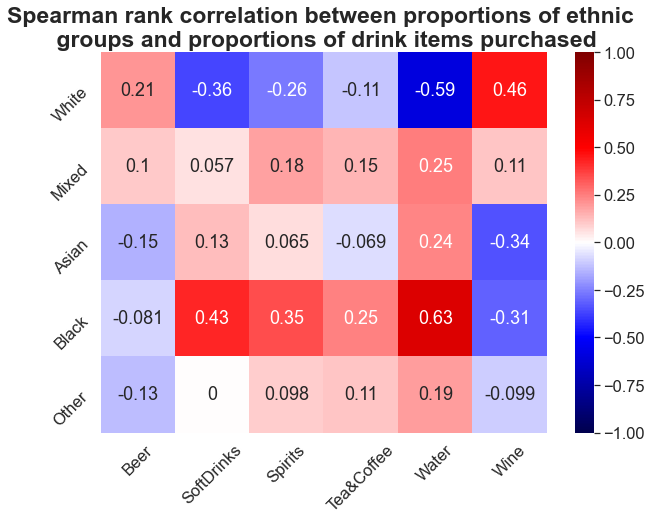

In [15]:
# keep only the significant data
# Bonferroni adjusted alpha
n_test = 85
alpha_adj = 0.05/n_test

plot_df = ff_corr_df.copy()
plot_df['R'][plot_df['p-value'] >= alpha_adj] = 0
plot_df

ethnicity_list = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]).tolist()
n_ethnicity = len(ethnicity_list)
n_food = 11
n_drink = 6

R_food_np = np.zeros((n_ethnicity, n_food))
R_drink_np = np.zeros((n_ethnicity, n_drink))

for i in range(n_ethnicity):
    R_food_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'food')]
    R_drink_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'drink')]


ethnicities_list = ['White',
                    'Mixed',
                    'Asian',
                    'Black',
                    'Other']    
    
food_list = ['Dairy',
             'Eggs',
             'Fats&oils',
             'Fish',
             'Fruit&veg',
             'Grains',
             'RedMeat',
             'Poultry',
             'Readymade',
             'Sauces',
             'Sweets']

drink_list = ['Beer',
              'SoftDrinks',
              'Spirits',
              'Tea&Coffee',
              'Water',
              'Wine']


plt.figure(figsize=(16,7))
ax = sns.heatmap(R_food_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Spearman rank correlation between proportions of ethnic groups \n and proportions of food items purchased', 
             fontsize=23, fontweight='bold')

ax.set_xticklabels(food_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)


plt.figure(figsize=(10,7))
ax = sns.heatmap(R_drink_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Spearman rank correlation between proportions of ethnic \n groups and proportions of drink items purchased', 
             fontsize=23, fontweight='bold')

ax.set_xticklabels(drink_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)
plt.show()

---



## 4. Causality analysis

### Naive initial analysis using Linear Regression

To get an idea of the effect of multiple features on food purchase diversity, we first performed a linear regression analysis. 

From our intuition, we selected features that we initially thought impacted food purchase diversity the most. We standardized them to be able to interpret better the weight of each feature selected on the output feature (`h_items`).

In [16]:
employment_rate = full_df['Economic_Activity;Employment_Rate;2011']
employment_rate_stand = (employment_rate - np.mean(employment_rate))/np.std(employment_rate)

median_household_income = full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']
median_household_income_stand = (median_household_income - np.mean(median_household_income))/np.std(median_household_income)

avg_age = full_df['avg_age']
avg_age_stand = (avg_age - np.mean(avg_age))/np.std(avg_age)

h_items = full_df['h_items_norm']
h_items_stand = (h_items - np.mean(h_items))/np.std(h_items)

h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011']
h_ethnicity_stand = (h_ethnicity - np.mean(h_ethnicity))/np.std(h_ethnicity)

We then build a dataframe containing the data that will be used in this part of the analysis.

In [17]:
lin_reg_df = pd.DataFrame()
lin_reg_df['employment_rate'] = employment_rate_stand
lin_reg_df['median_household_income'] = median_household_income_stand
lin_reg_df['avg_age'] = avg_age_stand
lin_reg_df['h_items'] = h_items_stand
lin_reg_df['h_ethnicity'] = h_ethnicity_stand
lin_reg_df.head()

,employment_rate,median_household_income,avg_age,h_items,h_ethnicity
LSOA11NM,,,,,
City of London 001A,1.465458,1.971130,3.214820,-1.382446,-1.378456
City of London 001B,1.453738,1.867475,2.976434,-1.104701,-1.896204
City of London 001C,0.563031,-0.119432,3.232598,0.359911,-0.798115
City of London 001E,-0.409714,-1.025721,-0.162352,-0.182977,0.927231
Barking and Dagenham 016A,-0.444873,0.295365,-1.102792,-0.245228,0.639302


First, we will try to keep only the ethnic entropy (`h_ethnicity`) to try to explain the food purchase entropy (`h_items`). We will use the statsmodels module.

In [18]:
formula = 'h_items ~ h_ethnicity'

mod = smf.ols(formula=formula, data=lin_reg_df)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                h_items   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     625.3
Date:                Wed, 16 Dec 2020   Prob (F-statistic):          7.00e-130
Time:                        23:16:44   Log-Likelihood:                -6563.6
No. Observations:                4833   AIC:                         1.313e+04
Df Residuals:                    4831   BIC:                         1.314e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.323e-15      0.014   9.77e-14      

---

We observe that 11.5% of the variance of `h_items` is explained by `h_ethnicity`, and that the effect is significant.


We will now try to explain the variance in the food purchase entropy (`h_items`) with the following features of each LSOA:
- The ethnic entropy: `h_ethnicity`
- The employment rate: `employment_rate`
- The average age: `avg_age`
- The median income per household: `median_household_income`

The results will give us an idea about the contribution and significance of each term when predicting the value of `h_items`

In [19]:
formula = 'h_items ~ h_ethnicity + employment_rate + avg_age + median_household_income'

mod = smf.ols(formula=formula, data=lin_reg_df)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                h_items   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     268.4
Date:                Wed, 16 Dec 2020   Prob (F-statistic):          1.30e-208
Time:                        23:16:44   Log-Likelihood:                -6372.5
No. Observations:                4833   AIC:                         1.275e+04
Df Residuals:                    4828   BIC:                         1.279e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

---

When adding the employment rate, the median household income and the average age of the LSOA's population in the predicting factors, $R^2$ only rises from 11.5 to 18.2 %. This seems to suggest that the ethnic entropy has a non-negligible effect on the food purchase category entropy.

From these results, it looks like all four predictive factors have a significant effect on the food purchase entropy. They suggest the following conclusions:
- LSOA with more ethnic diversity tend to have a larger food consumption diversity
- LSOA with a higher employment rate tend to have a larger food consumption diversity
- LSOA with a higher average age tend to have a lower food consumption diversity
- LSOA with a larger median income per household tend to have a lower food consumption diversity

As the features are standardized, the magnitude of their coefficients can be directly compared. This suggests that `median_household_income` impacts `h_items` the most, followed by `h_ethnicity`, `employment_rate` and finally `avg_age`. Even though it seems that ethnic diversity has an effect on food purchase diversity in an LSOA, we still need to be careful with the conclusions we might take here. Indeed, we could be in a situation where for example the `median_household_income` feature is a confounder and therefore it influences both `h_items` and `h_ethnicity`. We could therefore see an effect of `h_ethnicity` on `h_items`, even though it is actually `median_household_income` which impacts both indirectly. In this case, the effect of `h_ethnicity` on `h_items` could entirely be explained by `median_household_income`. To ensure that we are not in such a situation, we will use the notion of matching. We will perform Generalized Propensity Score (GPS) matching. This will allow us to take into account and remove the effect of potential confounders in the analysis of the ethnic entropy's effect on food purchase entropy.

Let us now select the most significant features of the full dataset from a statistical viewpoint, to reduce the dimensionality of the statistical analysis.

### Propensity Score matching

In [20]:
def filter_for_analysis( df ):

    lone_rel_col = ['h_items_norm',
                    'Ethnic_Group;h_ethnicities_norm;2011',
                    'Country_of_Birth;ratio_United_Kingdom;2011',
                    'Household_Language;ratio_of_households_with_at_least_one_person_aged_16_or_over_with_English_as_a_main_language;2011']
    out_df = df.loc[:, lone_rel_col]
    
    out_df = pd.concat([ out_df, df.loc[:, 'representativeness_norm':'people_per_sq_km' ] ], axis=1)
    out_df = pd.concat([ out_df, df.loc[:, 'Households;All_households;2011':'Household_Composition;ratio_Other_multi_person_household;2011'] ], axis=1)
    out_df = pd.concat([ out_df, df.loc[:, 'Religion;Christian_(ratio);2011': ] ], axis=1)
    
    # found out the columns are not all numeric
    for col in out_df.columns:
        out_df[col] = pd.to_numeric(out_df[col])
    
    out_df.reset_index(inplace=True)
    out_df.drop(['LSOA11NM'], axis=1, inplace=True)
    out_df.dropna(axis=1, inplace=True)
    
    return out_df
    
filtered_df = filter_for_analysis(full_df)

### New entropy features

In [21]:
household_compo_col_list = ['Household_Composition;ratio_Couple_household_with_dependent_children;2011',
                            'Household_Composition;ratio_Lone_parent_household;2011',
                            'Household_Composition;ratio_One_person_household;2011',
                            'Household_Composition;ratio_Other_multi_person_household;2011']

religion_col_list = ['Religion;Christian_(ratio);2011', 'Religion;Buddhist_(ratio);2011',
                     'Religion;Hindu_(ratio);2011', 'Religion;Jewish_(ratio);2011',
                     'Religion;Muslim_(ratio);2011', 'Religion;Sikh_(ratio);2011',
                     'Religion;Other_religion_(ratio);2011',
                     'Religion;No_religion_(ratio);2011',
                     'Religion;Religion_not_stated_(ratio);2011']

tenure_col_list = ['Tenure;Owned_outright_(ratio);2011',
                   'Tenure;Owned_with_a_mortgage_or_loan_(ratio);2011',
                   'Tenure;Social_rented_(ratio);2011',
                   'Tenure;Private_rented_(ratio);2011']

dwelling_col_list = ['Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011',
                     'Dwelling_type;Household_spaces_with_no_usual_residents_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Semi-detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Terraced_(including_end-terrace)_(ratio);2011',
                     'Dwelling_type;Flat,_maisonette_or_apartment_(ratio);2011']

eco_activity_col_list = ['Economic_Activity;Economically_active:_Employee;2011',
                         'Economic_Activity;Economically_active:_Self-employed;2011',
                         'Economic_Activity;Economically_active:_Unemployed;2011',
                         'Economic_Activity;Economically_active:_Full-time_student;2011']

qualif_col_list = ['Qualifications;ratio_No_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_1_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_2_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Apprenticeship;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_3_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_4_qualifications_and_above;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Other_qualifications;2011',
                   'Qualifications;ratio_Schoolchildren_and_full-time_students:_Age_18_and_over;2011']

health_activ_col_list = ['Health;Day-to-day_activities_limited_a_lot_(ratio);2011',
                         'Health;Day-to-day_activities_limited_a_little_(ratio);2011',
                         'Health;Day-to-day_activities_not_limited_(ratio);2011']

health_state_col_list = ['Health;Very_good_or_Good_health_(ratio);2011',
                         'Health;Fair_health_(ratio);2011',
                         'Health;Bad_or_Very_Bad_health_(ratio);2011']

car_avail_col_list = ['Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;1_car_or_van_in_household_(ratio);2011',
                      'Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011']

age_col_list = ['age_0_17', 'age_18_64', 'age_65+']



h_household_compo, h_household_compo_norm = compute_entropies(filtered_df, household_compo_col_list)
h_religion, h_religion_norm = compute_entropies(filtered_df, religion_col_list)
h_tenure, h_tenure_norm = compute_entropies(filtered_df, tenure_col_list)
h_dwelling, h_dwelling_norm = compute_entropies(filtered_df, dwelling_col_list)
h_eco_activity, h_eco_activity_norm = compute_entropies(filtered_df, eco_activity_col_list)
h_qualif, h_qualif_norm = compute_entropies(filtered_df, qualif_col_list)
h_health_activ, h_health_activ_norm = compute_entropies(filtered_df, health_activ_col_list)
h_health_state, h_health_state_norm = compute_entropies(filtered_df, health_state_col_list)
h_car_avail, h_car_avail_norm = compute_entropies(filtered_df, car_avail_col_list)
h_age, h_age_norm = compute_entropies(filtered_df, age_col_list)


# insert the new columns
new_h_idx = filtered_df.columns.get_loc('Country_of_Birth;ratio_United_Kingdom;2011') 
filtered_df.insert(new_h_idx, 'h_household_compo', h_household_compo.tolist(), True)
filtered_df.insert(new_h_idx, 'h_religion', h_religion.tolist(), True)
filtered_df.insert(new_h_idx, 'h_tenure', h_tenure.tolist(), True)
filtered_df.insert(new_h_idx, 'h_dwelling', h_dwelling.tolist(), True)
filtered_df.insert(new_h_idx, 'h_eco_activity', h_eco_activity.tolist(), True)
filtered_df.insert(new_h_idx, 'h_qualif', h_qualif.tolist(), True)
filtered_df.insert(new_h_idx, 'h_health_activ', h_health_activ.tolist(), True)
filtered_df.insert(new_h_idx, 'h_health_state', h_health_state.tolist(), True)
filtered_df.insert(new_h_idx, 'h_car_avail', h_car_avail.tolist(), True)
filtered_df.insert(new_h_idx, 'h_age', h_age.tolist(), True)


filtered_df.shape

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


(4833, 81)

We then standardize the dataset. Indeed, each feature is continuous and therefore we can directly perform it on the whole dataframe.

In [22]:
std_df = (filtered_df - filtered_df.mean()) / filtered_df.std()
std_df.sample(5)

,h_items_norm,Ethnic_Group;h_ethnicities_norm;2011,h_age,h_car_avail,h_health_state,h_health_activ,h_qualif,h_eco_activity,h_dwelling,h_tenure,...,Health;Very_good_or_Good_health_(ratio);2011,Health;Fair_health_(ratio);2011,Health;Bad_or_Very_Bad_health_(ratio);2011,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
3535,0.323252,1.230934,-1.520714,-1.690088,-0.258197,-0.544524,0.393680,0.165765,-1.491374,-0.382191,...,0.406518,-0.791790,0.190093,1.693923,-2.096457,-1.158356,-0.794576,-0.749174,-0.308652,-0.250983
2917,1.454480,0.059884,1.209237,0.890852,0.472184,1.003054,-0.218258,-0.265571,1.140840,1.137355,...,-0.499811,0.820471,-0.024951,-0.687773,0.445638,0.822007,0.302069,0.141681,0.049752,0.095722
1975,-0.107133,-1.222088,0.782703,0.784174,-2.238171,-2.043233,-3.012334,0.017374,1.085548,0.184753,...,1.998718,-1.814200,-1.906586,-0.833591,0.808794,0.761073,0.634386,-0.344240,2.114874,2.470917
2510,-0.649391,0.747286,-0.305749,-0.614360,0.211876,0.512206,0.548827,-0.134997,-0.884507,-0.985133,...,-0.132381,-0.005321,0.243855,0.370759,0.595910,-0.873996,-0.728113,-0.587200,-0.818010,-0.855316
3862,-0.363960,0.007181,-0.938040,-0.444724,-0.305368,-0.417999,-1.669074,-0.702755,0.512418,0.926398,...,0.406518,-0.516526,-0.186234,0.554382,-0.055268,-0.741972,-0.561955,-0.668187,0.927969,0.912492


The goal is now to select the features that we want to use in the propensity score. The output feature (i.e. the one we want to predict in the end) is `h_items_norm`, and we will therefore compute the Spearman correlation between `h_items_norm` and all the other features.

In [23]:
n_features = std_df.shape[1]

correl_df = pd.DataFrame(0, index=range(n_features-1), columns=['feature', 'correlation', 'p_value'])
correl_df['feature'] = std_df.columns[1:]

for i, col in enumerate(std_df.columns[1:]):
    correl, pval = spearmanr(std_df['h_items_norm'], std_df[col])
    correl_df.loc[i, 'correlation'] = correl
    correl_df.loc[i, 'p_value'] = pval

correl_df.head()

,feature,correlation,p_value
0,Ethnic_Group;h_ethnicities_norm;2011,0.368818,1.285898e-155
1,h_age,-0.251449,1.385551e-70
2,h_car_avail,-0.304450,3.426849e-104
3,h_health_state,0.271326,2.553374e-82
4,h_health_activ,0.180005,1.771874e-36


Let us now discard the features for which the correlation with the output feature is not significant (i.e. their associated p-value > 0.05)

In [24]:
# keep only the significant data
# Bonferroni adjusted alpha
n_test = len(correl_df)
alpha_adj = 0.05/n_test

filtered_correl_df = correl_df[ correl_df['p_value'] < alpha_adj ]

filtered_correl_df.shape

(74, 3)

Let's now sort the features from the most to the least correlated to `h_items_norm`, using the absolute value of the correlation coefficent.

In [25]:
filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)
sorted_correl_df.head(10)

,feature,correlation,abs_correlation,p_value
29,Household_Composition;ratio_Lone_parent_househ...,0.453982,0.453982,1.938682e-244
55,Economic_Activity;Economically_active:_Unemplo...,0.425294,0.425294,1.344982e-211
58,Economic_Activity;Unemployment_Rate;2011,0.417047,0.417047,9.912293e-203
41,Tenure;Owned_outright_(ratio);2011,-0.415181,0.415181,9.295447e-201
43,Tenure;Social_rented_(ratio);2011,0.412346,0.412346,8.727722e-198
52,Adults_in_Employment;ratio_of_households_with_...,0.402207,0.402207,2.178904e-187
28,Household_Composition;ratio_Couple_household_w...,-0.378579,0.378579,1.593143e-164
10,h_household_compo,0.369545,0.369545,2.856378e-156
0,Ethnic_Group;h_ethnicities_norm;2011,0.368818,0.368818,1.285898e-155
78,"Household_Income,_2011/12;Mean_Annual_Househol...",-0.352765,0.352765,1.258317e-141


Let's keep the top N features for the General Propensity Score computation. In this case, to simplify the readability and level of interpretation of the following results, we will use N = 10.

In [26]:
main_features = sorted_correl_df.head(10)['feature'].tolist()
main_features.append('h_items_norm')
features_df = std_df[main_features]
features_df.columns

Index(['Household_Composition;ratio_Lone_parent_household;2011',
       'Economic_Activity;Economically_active:_Unemployed;2011',
       'Economic_Activity;Unemployment_Rate;2011',
       'Tenure;Owned_outright_(ratio);2011',
       'Tenure;Social_rented_(ratio);2011',
       'Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011',
       'Household_Composition;ratio_Couple_household_without_dependent_children;2011',
       'h_household_compo', 'Ethnic_Group;h_ethnicities_norm;2011',
       'Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)',
       'h_items_norm'],
      dtype='object')

It turns out that the treatment feature (the ethnic entropy) is among the features kept. If it was not the case, it would not be a problem. However, it is encouraging for the rest of the analysis.

In [27]:
features_df = features_df.rename(columns={"Household_Composition;ratio_Lone_parent_household;2011": "lone_parents",
                            "Economic_Activity;Economically_active:_Unemployed;2011": "unemployed", 
                            "Economic_Activity;Unemployment_Rate;2011": "unemployment",
                            "Tenure;Owned_outright_(ratio);2011": "owned_tenure",
                            "Tenure;Social_rented_(ratio);2011": "social_rented_tenure",
                            "Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011":
                            "households_no_adults_employed",
                            "Household_Composition;ratio_Couple_household_without_dependent_children;2011": 
                            "couple_household_no_children",
                            "Ethnic_Group;h_ethnicities_norm;2011": "h_ethnic",
                            "Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)": "household_mean_income"})

In [28]:
#sns.pairplot(features_df);

With the following plot, we can get an idea of the correlation between the features that we want to use to compute the propensity score.

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

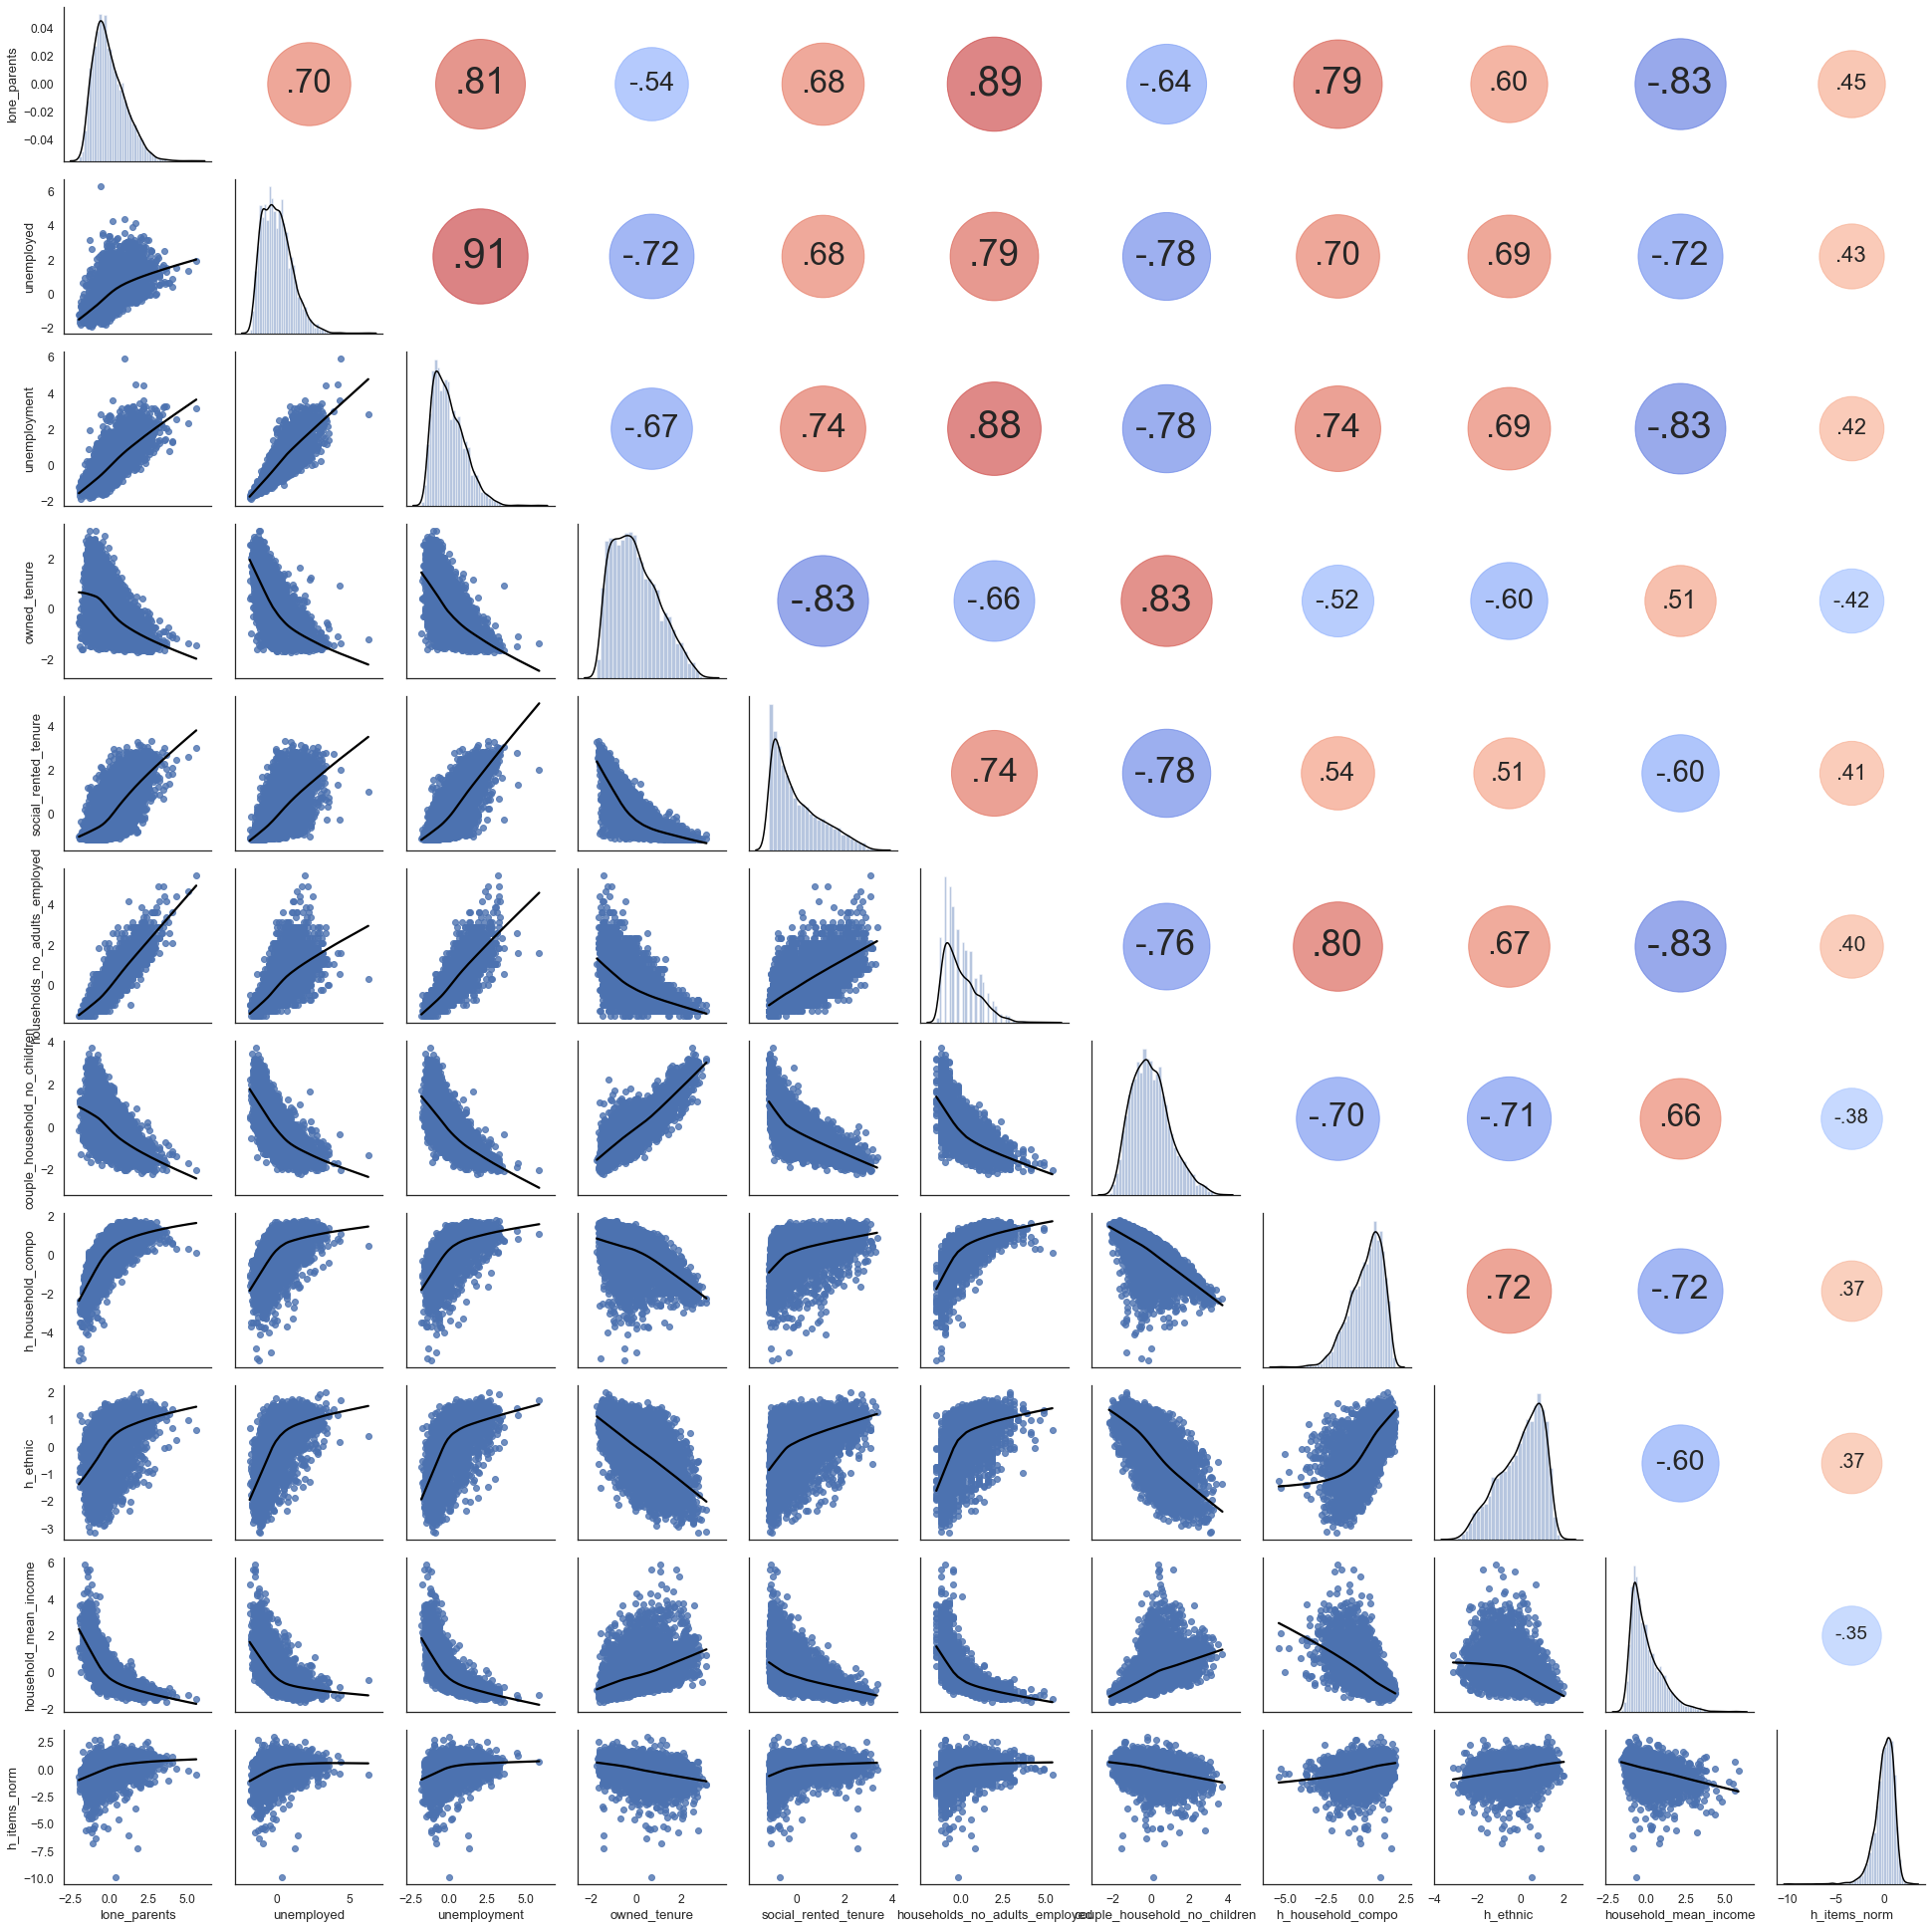

In [29]:
# source: https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.1)
#iris = sns.load_dataset('iris')
g = sns.PairGrid(features_df, aspect=1, diag_sharey=False);
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'});
g.map_diag(sns.distplot, kde_kws={'color': 'black'});
g.map_upper(corrdot);

As there are not two features with a very large correlation (> 0.95), we will keep all of them but the treatment feature for the propensity score computations.

### Towards propensity score matching with a continuous treatment feature

In the ADA course, we learned about propensity score matching. It is very useful to minimize the impact of confounders on the analysis of the effect of a feature (called the treatment) on another feature (called the output). Indeed, until now, we have focused on simple and naive correlations, giving no information about causality whatsoever, as well as linear regressions which only slightly bring a notion of causality in the analysis. To dig deeper in the analysis of the effect of ethnic diversity on food purchase diversity and to know if causality is involved here, we will perform a propensity score matching. The goal is to match samples together using a propensity score, which represents the probability that a sample has been treated (treatment value = 1, in opposition to 0 when not treated) based on the values of some of its other features (the ones used to compute the score). 

However, in the ADA course, propensity score matching was performed with a binary treatment feature. This makes it a lot easier. Indeed, by default it cuts the dataset in two groups whose respective samples can then be matched together. In this present case, the treatment we would like to study is the ethnic entropy, a continuous feature. As the dataset cannot really be cut in the same manner when using a continuous treatment feature, it is not as straightforward as the binary case. Of course, there is always the solution of binarizing the continuous feature. It can simply be done by setting a threshold in the treatment feature: the samples with a higher value form the first group and the samples with an equal or lower value form the second group. This solution has a critical drawback though: it makes it very difficult to interpret the results of the treatment effect. Indeed, if the matching works well, and in the end a significant effect is found, it means the following thing: if a sample belongs to the first group, the output feature is significantly larger/lower (depending on the effect of the treatment) than it would be if this sample was in the second group (and therefore if its treatment was lower). Let us say that the threshold is set such that the two resulting groups have the same size. As groups are formed via a threshold on a continuous feature, it means that being in the top 50 % of samples in terms of the treatment feature value impacts a sample's output feature. But what about a sample at 49 % compared to one at 51 %? Is there really such a hard boundary? In most cases, no. Indeed, the threshold is often arbitrary in the case of a continuous feature. 

To account for the fact that the treatment feature is continuous, we decided to use an implementation of Generalized Propensity Score (GPS) matching. Matching is performed on two values: the propensity score of the sample, computed using a regression on the features selected to build the score (potential confounders whose effect needs to be minimized), and its continuous treatment value. Similar samples on these two values are matched together. The output of the algorithm is called a Causal Dose Response (CDR) curve. It computes the effect of the treatment on the output by calculating the predicted output value in function of the treatment value. If the treatment has an effect, then the curve is not flat, i.e. the predicted output changes depending on the treatment. The GPS algorithm outputs a confidence interval and we can use it to assess the significance of the resulting CDR curve.

In [29]:
gps = GPS(gps_family=None,
          treatment_grid_num=100,
          lower_grid_constraint=0.2,
          upper_grid_constraint=0.8,
          spline_order=3,
          n_splines=15, # maximum number of turning points (knots) to be used during the smoothing process
          lambda_=0.5,
          max_iter=500,
          random_seed=None,
          verbose=False)

features = features_df.columns.to_list()
features.remove('h_items_norm')
#features.remove('h_ethnic')

treat_feat = 'h_ethnic'
features.remove(treat_feat)

# Fits the causal dose-response model.
gps.fit(T = features_df[treat_feat], 
        X = features_df[features], 
        y = features_df['h_items_norm'])

gps_results = gps.calculate_CDRC(0.95)

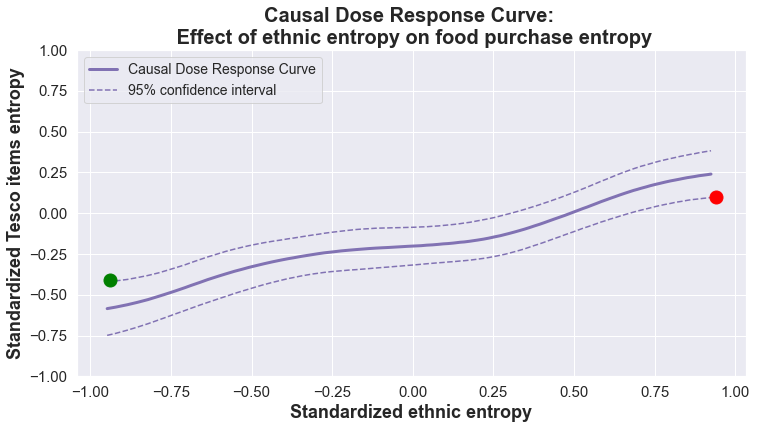

In [30]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve',
         c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.ylim(-1,1)
ax.legend()
plt.title('Causal Dose Response Curve: \n Effect of ethnic entropy on food purchase entropy',
          fontsize=20, fontweight='bold')
plt.xlabel('Standardized ethnic entropy', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

# plot points to highlight how the metric we will use works
plt.plot([-0.94], [-0.41], marker='o', markersize=13, color="green")
plt.plot([0.94], [0.1], marker='o', markersize=13, color="red")

plt.tick_params(labelsize=15)

plt.legend(loc=2, prop={'size': 14})

plt.show()

To measure the significance of the effect of ethnic entropy on food purchase entropy, we thought about a metric. It is quite straightforward and surely it already exists, but we have not been able to find anyone else using or defining it.

Let us look at the plot above to define this metric on a concrete example. In this case, the CDR curve has an approximately constant positive slope. We observe that no horizontal line can be drawn inside the confidence interval (CI). As a horizontal line corresponds to the treatment having no effect on the output, in the case of the curve above we interpret that the effect of the treatment on the output is significant.

Now, how can we capture this information using a simple and robust metric? If we look at the difference between the maximum value of the lower CI (the red dot on the plot) and the minimum value of the upper CI (the green dot), we observe that in this case it is positive. Indeed, the red dot has a larger y-value (standarized `h_items`) than the green dot. By definition, this difference being positive verifies that no horizontal line can be drawn inside the CI. Here is the value of the metric in this case:

In [31]:
treatment_effect_metric = (gps_results['Upper_CI'].min() - gps_results['Lower_CI'].max())
print("The causality significance metric has a value of {0:.3f}.".format(treatment_effect_metric))

The causality significance metric has a value of -0.516.


Let us compare this example to another one, to better grasp how this metric works. Here is the CDR curve, with the number of male in the area as a treatment feature.

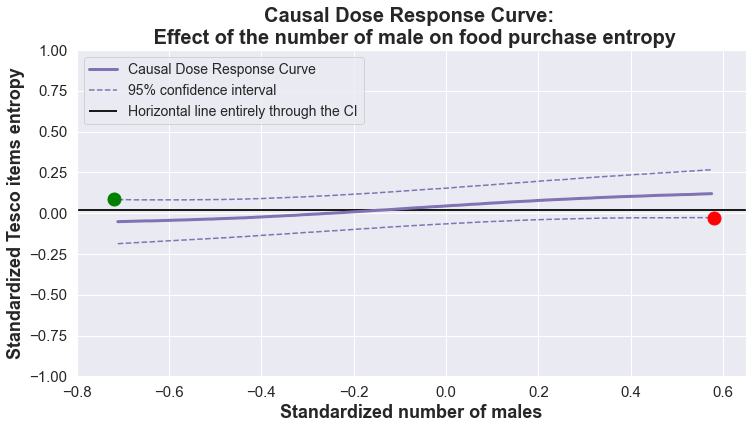

In [32]:
gps = GPS(gps_family=None, treatment_grid_num=100, lower_grid_constraint=0.2, upper_grid_constraint=0.8, spline_order=3,
          n_splines=15, lambda_=0.5, max_iter=500, random_seed=None, verbose=False)

features = features_df.columns.to_list()
features.remove('h_items_norm')

treat_feat = 'male'

gps.fit(T = std_df[treat_feat], X = features_df[features], y = features_df['h_items_norm'])
gps_results = gps.calculate_CDRC(0.95)

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve', c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.plot([-0.72], [0.09], marker='o', markersize=13, color="green")
plt.plot([0.58], [-0.03], marker='o', markersize=13, color="red")
plt.hlines(0.02, -1, 1, color='k', linewidth=2, label='Horizontal line entirely through the CI')

plt.title('Causal Dose Response Curve: \n Effect of the number of male on food purchase entropy', fontsize=20, fontweight='bold')
plt.xlabel('Standardized number of males', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

ax.legend()
plt.ylim(-1,1)
plt.xlim(-0.8,0.65)
plt.tick_params(labelsize=15)
plt.legend(loc=2, prop={'size': 14})

plt.show()

We can observe that in this case, the green dot has a larger y-value compared to the red dot, in turn meaning that the metric is negative. It is clear that a horizontal line can be drawn inside the CI, as shown by the black line; therefore we rate the effect of this treatment as non significant.

In [33]:
treatment_effect_metric = (gps_results['Upper_CI'].min() - gps_results['Lower_CI'].max())
print("The causality significance metric has a value of {0:.3f}.".format(treatment_effect_metric))

The causality significance metric has a value of 0.109.


The more positive this metric is, the more significant is the effect of the treatment. We do not need to normalize it, as we are already working with a standardized dataframe. In the two examples presented, the max of the lower CI and the min of the upper CI are on the bounds of the interval. Even when this is not the case, the metric still works just fine. Indeed, if we imagine a parabolic CDR curve, the metric will still be negative if a horizontal line can be drawn in the CI, and positive if not. 

This metric is really interesting thanks to the visual intuition it represents and to its simplicity. However, it has a slight drawback: it cannot always capture the magnitude of the treatment effect on the output. Indeed, if the CDR curve is not well estimated by a linear regression (i.e. if it does not look like a line), the value of the _causality significance metric_ could minimize the effect of the treatment. It will always be proportional to the difference between the highest estimated output value in function of the treatment, and its lowest estimated value (because the CI englobes the CDR curve and follows its variations), which is already interesting enough to give an idea of treatment effect magnitude.

### Modularity

We have now seen in details with the ethnic and food purchase entropies, how we can analyze those features to go from a correlation, telling us how strong the association between the two variables is, to a causality link between them. 
Let's create some functions to perform those analyses in a more condensed way, allowing us to test the causality link between many features appearing to be correlated or not.

To do so, we will use two functions.
- `compute_corr_df()`: Returns a standardized dataframe of the n most correlated features to an outcome feature, as well as a dataframe with the same features but not standardized
- `compute_GPS()`: Compute the Generalized Propensity Score between a treatment and an outcome feature, considering all the other features present in the dataframe as confounding factors. Returns our causality metric as well as the points of the causal dose response curve

In [35]:
##### Function to determine the most correlated features #####

def compute_corr_df(df, treatment_name, outcome_name, n=30, alpha=0.05):
    '''
    Standardize the df
    Compute the correlation between each features of the df and the outcome feature
    Select the significative correlations (for alpha)
    Return a df of only the n most correlated features & the outcome feat
    (& the treatment if not in the most correlated features) 
    Return another df, that is similar but not standardized
    '''
    
    # standardize the df
    std_df = (df - df.mean()) / df.std()
    
    correl_df = pd.DataFrame(0, index=range(df.shape[1]-1), columns=['feature', 'correlation', 'p_value'])
    features = list(df.columns.values)
    features.remove(outcome_name)  
    correl_df['feature'] = features
    
    # compute the correlation on the standardized df
    for i, col in enumerate(features):
        correl, pval = spearmanr(std_df[outcome_name], std_df[col])
        correl_df.loc[i, 'correlation'] = correl
        correl_df.loc[i, 'p_value'] = pval
        
    alpha_adj = alpha/len(correl_df)
    filtered_correl_df = correl_df[correl_df['p_value'] < alpha_adj]
    filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
    sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)
    
    main_features = sorted_correl_df.head(n)['feature'].tolist()
    main_features.append(outcome_name)
    
    ## Check if the treatment is one of the most correlated features, otherwise add it
    if not treatment_name in main_features:
        main_features.append(treatment_name)
    
    corr_features_df = df[main_features]
    std_corr_features_df = std_df[main_features]
    
    return corr_features_df, std_corr_features_df



##### Function to compute the Generalized propensity Score #####

def compute_GPS(df, std_df, treatment_name, outcome_name, plot_std=False, plot_normal=False, CI=0.95, 
                ymin_std=-1, ymax_std=1):
    '''
    Compute the generalized propensity score to determine the Causal Dose Response Curve
    between the treatment and the outcome, considering the other features of the df as confounders
    '''
    gps = GPS(treatment_grid_num=100, lower_grid_constraint=0.2, upper_grid_constraint=0.8, n_splines=15)
    
    features = std_df.columns.to_list()
    features.remove(treatment_name)
    features.remove(outcome_name)

    # Fits the causal dose-response model.
    gps.fit(T = std_df[treatment_name], 
            X = std_df[features], 
            y = std_df[outcome_name])
    
    gps_results = gps.calculate_CDRC(CI)
    
    if plot_std:
        fig, ax = plt.subplots(figsize=(12,6))
        plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], 
                 label='Causal Dose Response Curve', linewidth=3)
        plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'k--', label='95% confidence interval')
        plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'k--')
        plt.ylim(ymin_std,ymax_std)
        plt.xlim(-1,1)
        ax.legend()
        plt.title('Causal Dose Response Curve')
        plt.xlabel('Standardized Treatment: ' + treatment_name)
        plt.ylabel('Standardized Outcome: ' + outcome_name)
        plt.show()
        
    if plot_normal:
        
        # destandardize the values
        treat_destd = gps_results['Treatment']*np.std(df[treatment_name]) + np.mean(df[treatment_name])
        
        std_out = np.std(df[outcome_name])
        mean_out = np.mean(df[outcome_name])
        cdr_destd = gps_results['Causal_Dose_Response']*std_out + mean_out
        cdr_destd_low95 = gps_results['Lower_CI']*std_out + mean_out
        cdr_destd_up95 = gps_results['Upper_CI']*std_out + mean_out
        
        #plot
        fig, ax = plt.subplots(figsize=(12,6))
        plt.plot(treat_destd, cdr_destd, label='Causal Dose Response Curve',linewidth=3)
        plt.plot(treat_destd, cdr_destd_low95, 'k--', label='95% confidence interval')
        plt.plot(treat_destd, cdr_destd_up95, 'k--')
        ax.legend()
        plt.title('Causal Dose Response Curve')
        plt.xlabel('Treatment: ' + treatment_name)
        plt.ylabel('Outcome: ' + outcome_name)
        plt.show()
    
    treatment_effect_metric = (gps_results['Lower_CI'].max() - gps_results['Upper_CI'].min())
    
    return gps_results, treatment_effect_metric


### Assessing our approach
We have seen that by considering as confounders to the treatment (ethnicity diversity) the features present in the 10 most correlated features to the outcome (food purchase diversity), it results that the correlation observed between those two diversity measures appear to be also causal. 
However, the choice of considering only the 10 most correlated features as potential confounders is arbitrary. Therefore, let's check that this arbitrary choice has no influence on the conclusion drown by looking at the causality metric we obtain considering a more important number of the most correlated to the outcome features.

In [36]:
nb_corr_feat = range(1, 51)
caus_metric = []
treat_feat = 'Ethnic_Group;h_ethnicities_norm;2011'

for nb in nb_corr_feat:
    corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat_feat, 'h_items_norm', n=nb)
    _, treat_eff_met = compute_GPS(corr_features_df, std_corr_features_df, treat_feat, 'h_items_norm')
    caus_metric.append(treat_eff_met)

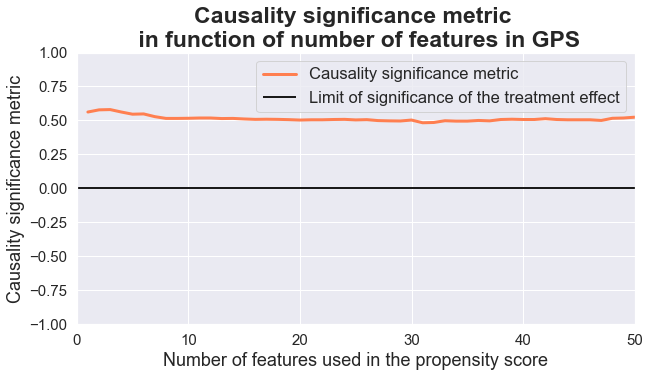

In [37]:
plt.figure(figsize=(10,5))

plt.plot(nb_corr_feat, caus_metric, linewidth=3, color='coral', label='Causality significance metric');
plt.hlines(0, -5, 65, colors='k', linewidth=2, label='Limit of significance of the treatment effect')

plt.title('Causality significance metric \n in function of number of features in GPS', fontsize=23, fontweight='bold')
plt.xlabel('Number of features used in the propensity score', fontsize=18)
plt.ylabel('Causality significance metric', fontsize=18)
plt.tick_params(labelsize=15)

plt.ylim(-1,1);
plt.xlim(0,50)

plt.legend()
plt.show()

Our causality metric doesn't change when considering more correlated features as potential confounders. This tends to assess that considering only the 10 most correlated features is enough to determine the causality between the treatment and the outcome removing the effect of potential confounders. 
However, to ensure that this is not specific to this example and that we are considering enough potential confounders for each analysis, for the following analyses, we will take into account the 30 most correlated features to the outcome as potential confounders of the treatment.

Now let's check that not all the features correlated to the food purchase diversity appear to have a causality link with this latter. If it was the case, then this would mean that something went wrong in our analysis as we aim to identify what are the real causal links that can be observed from the correlated features and not just having another metric that is similar to the correlation. 

In [38]:
## First determine all the features correlated to the diversity in food purchase
## and their correlation value
outcome_name = 'h_items_norm'

# standardize the df
std_df = (filtered_df - filtered_df.mean()) / filtered_df.std()

correl_df = pd.DataFrame(0, index=range(filtered_df.shape[1]-1), 
                         columns=['feature', 'correlation', 'p_value'])

features = list(filtered_df.columns.values)
features.remove(outcome_name)  
correl_df['feature'] = features

# compute the correlation on the standardized df
for i, col in enumerate(features):
    correl, pval = spearmanr(std_df[outcome_name], std_df[col])
    correl_df.loc[i, 'correlation'] = correl
    correl_df.loc[i, 'p_value'] = pval
    
alpha_adj = 0.05/len(correl_df)

filtered_correl_df = correl_df[correl_df['p_value'] < alpha_adj]
filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)

corr_features = sorted_correl_df['feature'].tolist()

In [39]:
sorted_correl_df

,feature,correlation,abs_correlation,p_value
29,Household_Composition;ratio_Lone_parent_househ...,0.453982,0.453982,1.938682e-244
55,Economic_Activity;Economically_active:_Unemplo...,0.425294,0.425294,1.344982e-211
58,Economic_Activity;Unemployment_Rate;2011,0.417047,0.417047,9.912293e-203
41,Tenure;Owned_outright_(ratio);2011,-0.415181,0.415181,9.295447e-201
43,Tenure;Social_rented_(ratio);2011,0.412346,0.412346,8.727722e-198
...,...,...,...,...
7,h_dwelling,-0.082974,0.082974,7.612127e-09
39,Religion;No_religion_(ratio);2011,0.080159,0.080159,2.403181e-08
61,Qualifications;ratio_Highest_level_of_qualific...,0.075731,0.075731,1.356561e-07
12,Household_Language;ratio_of_households_with_at...,-0.072796,0.072796,4.059580e-07


In [40]:
# then compute the causality metric considering 30 potential confounders 
caus_metric = []

for treat_feat in corr_features:
    corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat_feat, 'h_items_norm')
    _, treat_eff_met = compute_GPS(corr_features_df, std_corr_features_df, treat_feat, 'h_items_norm')
    caus_metric.append(treat_eff_met)

In [41]:
corr_caus_df = sorted_correl_df[['feature', 'correlation']]
corr_caus_df.insert(2, 'caus_metric', caus_metric)
#is_causal = [True if met < 0 else False for met in caus_metric]
#corr_caus_df['is_causal'] = is_causal

In [47]:
corr_rank = range(1,len(sorted_correl_df)+1)
corr_caus_df['corr_rank'] = corr_rank

sort_caus_df = corr_caus_df.sort_values('caus_metric', ascending=False)
caus_rank = range(1,len(sort_caus_df)+1)
sort_caus_df['caus_rank'] = caus_rank

sort_df = sort_caus_df.sort_values('corr_rank', ascending=True)
sort_df['change_in_rank'] = sort_df['corr_rank'] - sort_df['caus_rank']

In [48]:
# We change the Pandas parameters to be able to display the whole data

pd.set_option("display.max_rows", None, "display.max_columns", None)
display(sort_df)

,feature,correlation,caus_metric,corr_rank,caus_rank,change_in_rank
29,Household_Composition;ratio_Lone_parent_househ...,0.453982,0.480,1,5,-4
55,Economic_Activity;Economically_active:_Unemplo...,0.425294,0.514,2,2,0
58,Economic_Activity;Unemployment_Rate;2011,0.417047,0.458,3,6,-3
41,Tenure;Owned_outright_(ratio);2011,-0.415181,0.394,4,7,-3
43,Tenure;Social_rented_(ratio);2011,0.412346,0.543,5,1,4
52,Adults_in_Employment;ratio_of_households_with_...,0.402207,0.481,6,4,2
28,Household_Composition;ratio_Couple_household_w...,-0.378579,0.351,7,9,-2
10,h_household_compo,0.369545,0.334,8,10,-2
0,Ethnic_Group;h_ethnicities_norm;2011,0.368818,0.503,9,3,6
78,"Household_Income,_2011/12;Mean_Annual_Househol...",-0.352765,0.267,10,16,-6


In [44]:
# We change the Pandas parameters to be able to display the whole data
pd.set_option("display.max_rows", 10, "display.max_columns", 20)

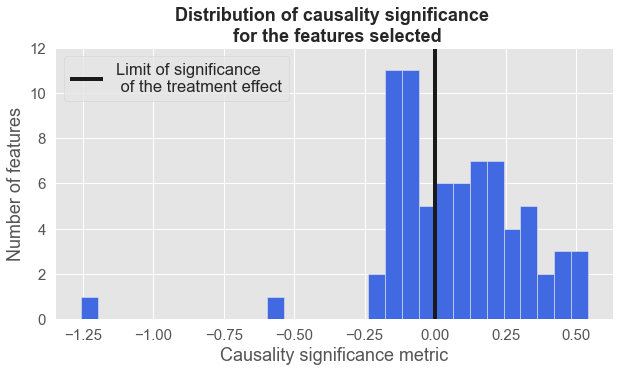

In [66]:
style.use('ggplot')

plt.figure(figsize=(10,5))
plt.hist(caus_metric, color='royalblue', bins=30)
plt.vlines(0,0,20, color='k', label="Limit of significance \n of the treatment effect", linewidth=4)
plt.title("Distribution of causality significance \n for the features selected", fontsize=18, fontweight='bold')
plt.xlabel('Causality significance metric', fontsize=18)
plt.ylabel('Number of features', fontsize=18)
plt.tick_params(labelsize=15)

plt.ylim(0,12)

#plt.legend()
plt.legend(loc=2)
plt.show()

In [82]:
#np.sum(is_causal)

43

In [103]:
col_causal = ['aliceblue' if met < 0 else 'lightpink' for met in caus_metric]

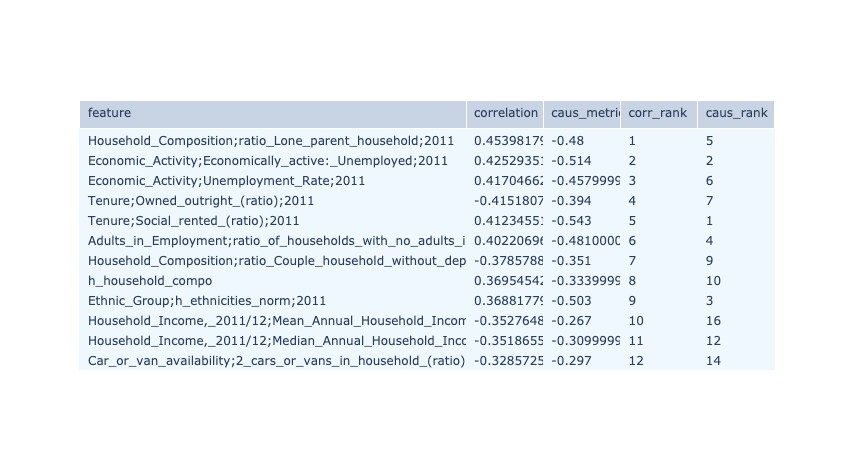

In [104]:
fig = go.Figure(data=[go.Table(
    columnwidth = [400,80,80],
    header=dict(values=list(sort_df.columns[0:5]),
                #fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[sort_df.feature, sort_df.correlation, 
                       sort_df.caus_metric, sort_df.corr_rank, sort_df.caus_rank],
               line_color=[col_causal], fill_color=[col_causal],
               #fill_color='lavender',
               align='left'))
])

fig.show()

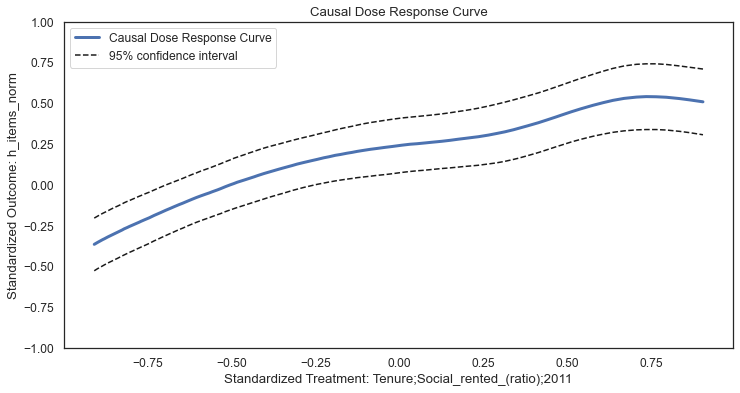

In [88]:
corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, 'Tenure;Social_rented_(ratio);2011',
                                                          'h_items_norm')
_, _ = compute_GPS(corr_features_df, std_corr_features_df, 'Tenure;Social_rented_(ratio);2011',
                   'h_items_norm', plot_std=True)

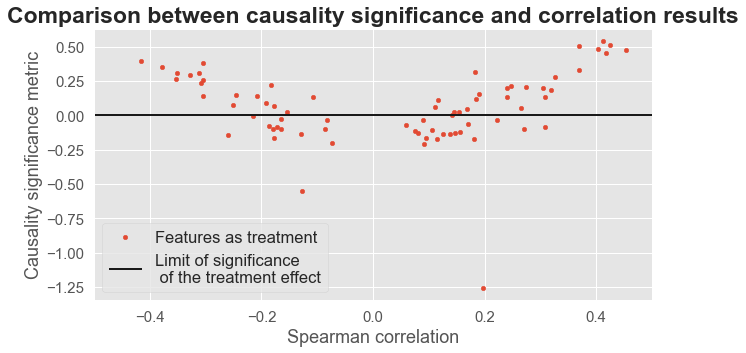

In [73]:
plt.figure(figsize=(10,5))

plt.scatter(corr_caus_df.correlation, corr_caus_df.caus_metric, s=20, label='Features as treatment')
plt.hlines(0, -0.7, 0.7, colors='k', linewidth=2, label='Limit of significance \n of the treatment effect');
#plt.hlines(-0.1, -0.5, 0.5, colors='m', Linestyle='--'); # safety factor ?
plt.xlabel('Spearman correlation', fontsize=18)
plt.ylabel('Causality significance metric', fontsize=18)
plt.title("Comparison between causality significance and correlation results", fontsize=23, fontweight='bold')

plt.xlim(-0.5, 0.5)
plt.tick_params(labelsize=15)

plt.legend()
plt.show()

With those results, we can observe that the ethnicity diversity appears to be the 3rd most causal feature of the food purchase diversity, just behind the feature of the number of person unemployed and the feature of the ratio of social rented tenure in the area.
We can also see that many features that are correlated to the food purchase diversity are in fact not showing any causality link with this feature when considering confounding factors.
In addition, we can observe on the scatter that even though there is a trend showing that the more correlated (in absolute value), the more causal the relationship between the two variables is, this relation is not perfect. This further assess our analysis and findings that there is indeed a causal link between the ethnicity diversity and the food purchase diversity of an area. 


## Is our ethnicity reflected in our food consumption ? 
Now that we have clearly identified that the more diverse the population is (in terms of ethnicity), the more diverse the food purchase will be, let's come back to our main question of interest. 

Can we identify food items that are specific to a certain ethnicity ? 

We have seen at the the beginning the different ethnicities were correlated in specific manners to the different food items. However, as for the study done with the food purchase and ethnicity diversity we would like to determine whether those correlations lead to causal links between the different features.

To determine this, we process in a similar manner than previously, computing a generalized propensity score between a treatment and an outcome to remove the effect of confounding factors allowing to identify a causality link between the features.

In [118]:
ethnic_features = ['Ethnic_Group;White_(ratio);2011',
                   'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
                   'Ethnic_Group;Asian/Asian_British_(ratio);2011',
                   'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
                   'Ethnic_Group;Other_ethnic_group_(ratio);2011']

ethnic_feat_short = ['White', 'Mixed', 'Asian', 'Black', 'Other']

food_features = ['f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 
                 'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_sweets']

drink_features = ['f_beer', 'f_soft_drinks', 'f_spirits','f_tea_coffee', 'f_water', 'f_wine']

In [119]:
filtered_df.index = full_df.index
filtered_df = pd.concat([filtered_df, full_df.loc[:,food_features]], axis=1)
filtered_df = pd.concat([filtered_df, full_df.loc[:,drink_features]], axis=1)
filtered_df = pd.concat([filtered_df, full_df.loc[:,ethnic_features]], axis=1)

In [122]:
res_food_df = pd.DataFrame(columns=['out', 'treat', 'metric'])
caus_curve_food_df = pd.DataFrame(columns=['Treatment', 'Causal_Dose_Response', 
                                           'Lower_CI', 'Upper_CI', 'outcome', 'treatment'])

for outcome in food_features:
    print(outcome)
    for i, treat in enumerate(ethnic_features):
        corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat, outcome)
        gps_res, treat_eff_metric = compute_GPS(corr_features_df, std_corr_features_df, treat, outcome)
        res_food_df = res_df.append({'out': outcome, 'treat': ethnic_feat_short[i], 
                                     'metric': treat_eff_metric}, ignore_index=True)  
        gps_res['outcome'] = np.repeat(outcome, 100)
        gps_res['treatment'] = np.repeat(ethnic_feat_short[i], 100)
        caus_curve_food_df = caus_curve_food_df.append(gps_res, ignore_index=True)
        
        # repeat elements to have same length and suitable format
        #ethnicity_col = np.repeat(ethnicity_col, n_category)
        #category_col = np.tile(category_col, n_ethnicity)
        #list_gps_df.append(gps_res)
        #res_food_df = res_df.append({'out': outcome, 'treat': ethnic_feat_short[i], 
        #                             'metric': treat_eff_metric}, ignore_index=True)  

f_dairy
f_eggs
f_fats_oils
f_fish
f_fruit_veg
f_grains
f_meat_red
f_poultry
f_readymade
f_sauces
f_sweets


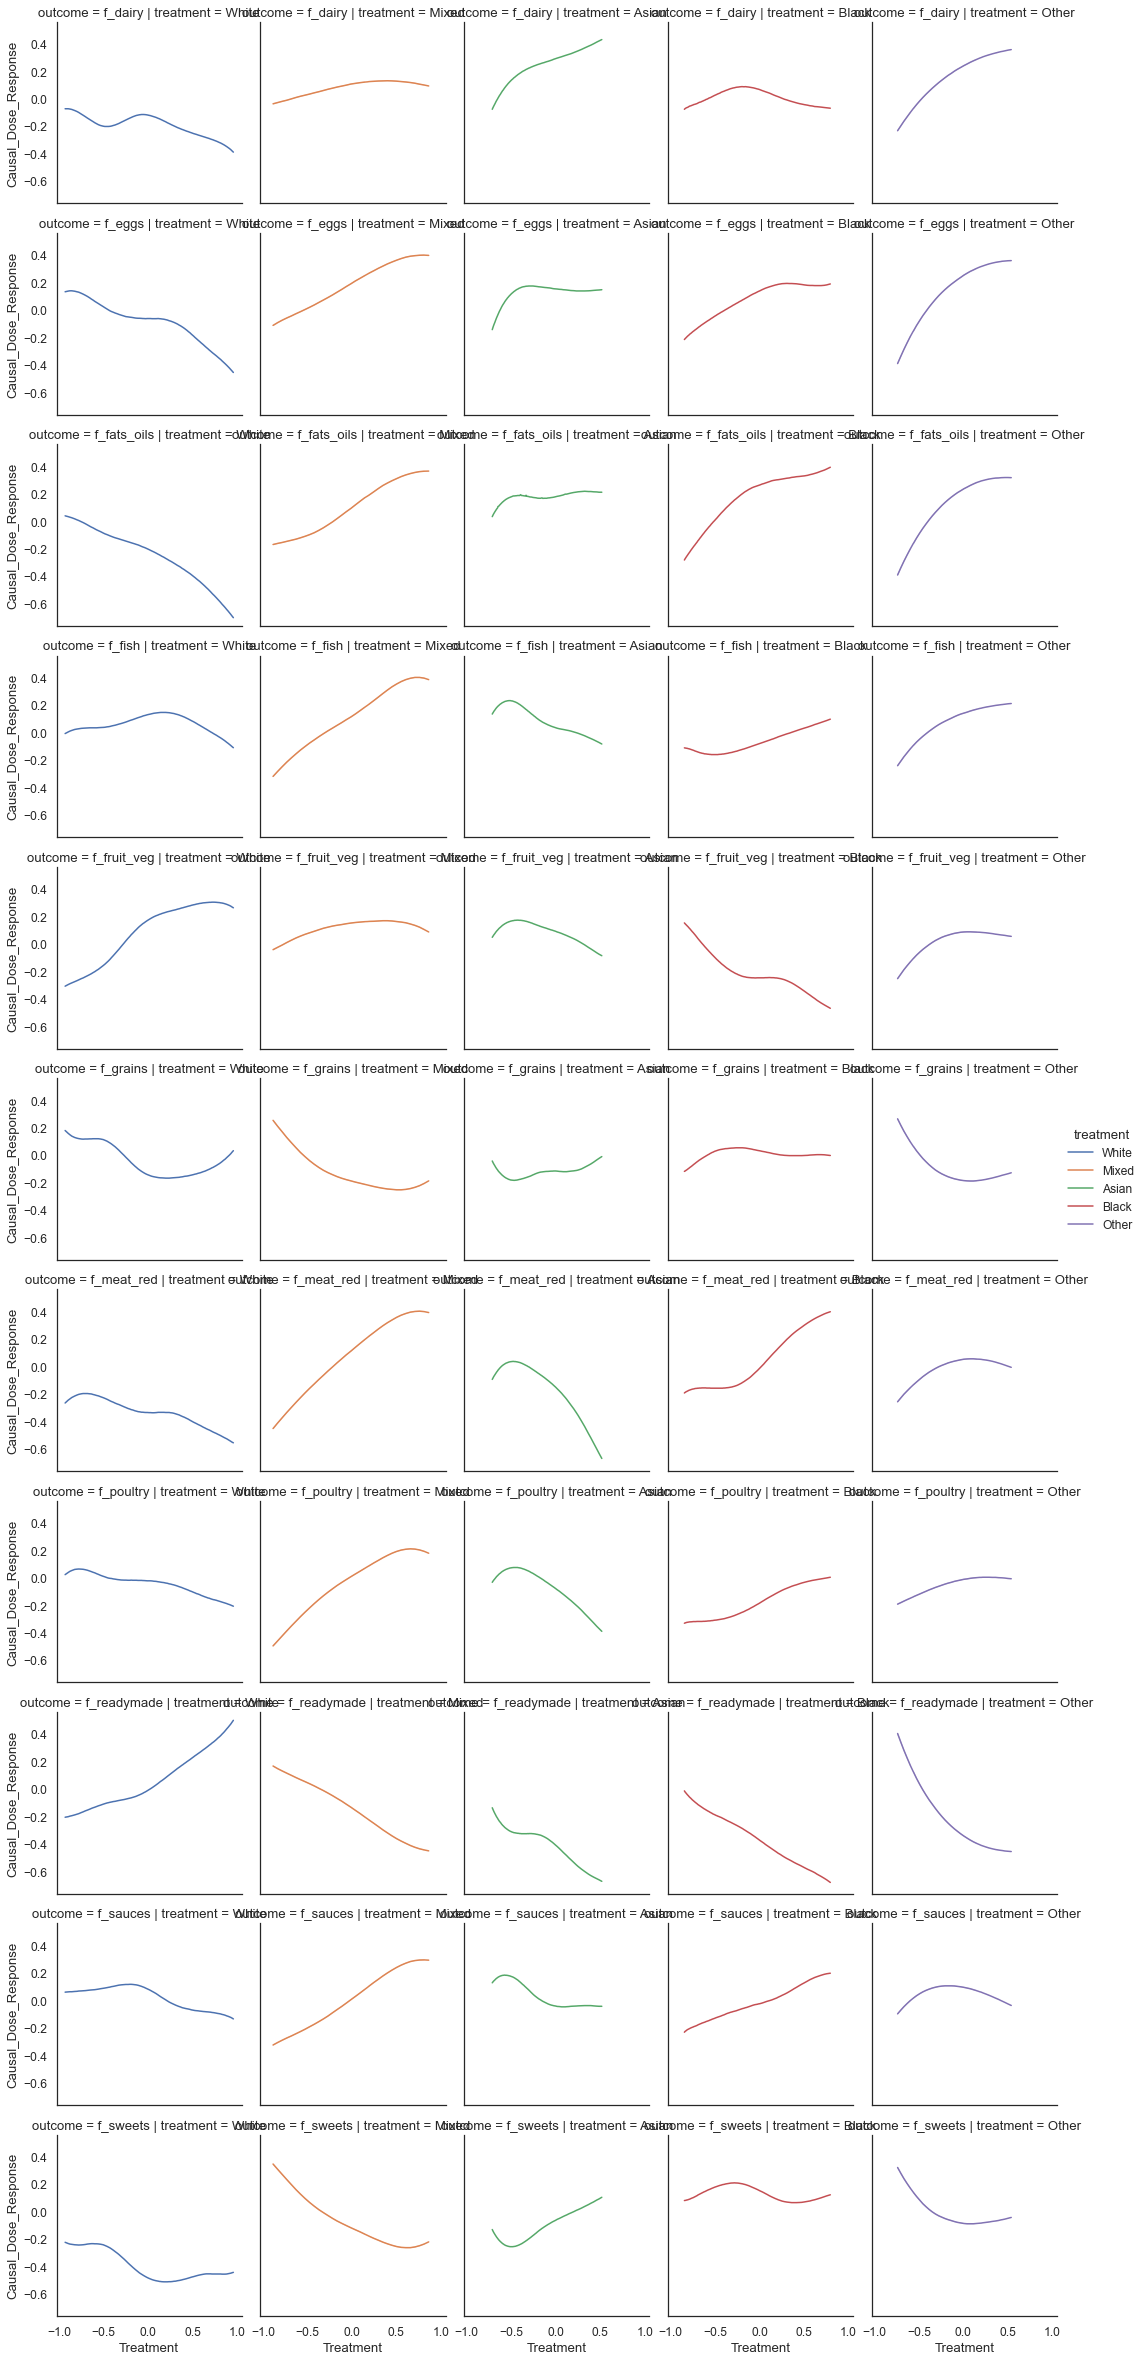

In [130]:
grid = sns.FacetGrid(caus_curve_food_df, row='outcome', col='treatment', hue='treatment')
grid.map(sns.lineplot, 'Treatment', 'Causal_Dose_Response')
#grid.map(sns.lineplot, 'Treatment', 'Lower_CI', dashes=True)
#grid.map(sns.lineplot, 'Treatment', 'Upper_CI', dashes=True)
grid.add_legend()
plt.show()

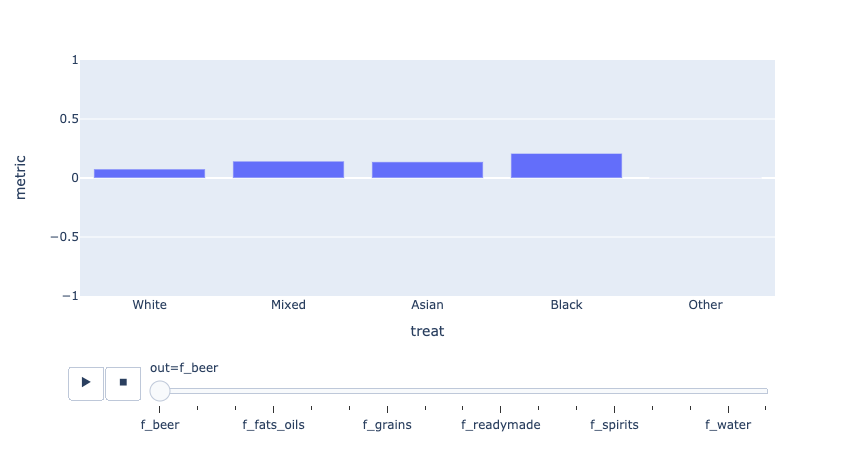

In [147]:
fig = px.bar(res_df, x="treat", y="metric", animation_frame="out", range_y=[-1,1],
             #color='sign_metric',
             category_orders=dict({'treat': ['White', 'Mixed', 'Asian', 'Black', 'Other']}))

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000
fig.show()

In [106]:
res_df

,out,treat,metric
0,f_beer,White,0.076
1,f_beer,Mixed,0.143
2,f_beer,Asian,0.137
3,f_beer,Black,0.209
4,f_beer,Other,0.002
...,...,...,...
80,f_wine,White,-0.691
81,f_wine,Mixed,0.095
82,f_wine,Asian,-0.462
83,f_wine,Black,-0.308


In [105]:
list_gps_df[0]

,Treatment,Causal_Dose_Response,Lower_CI,Upper_CI
0,-0.934,-0.346,-0.576,-0.117
1,-0.899,-0.327,-0.556,-0.098
2,-0.880,-0.318,-0.546,-0.090
3,-0.859,-0.309,-0.536,-0.082
4,-0.826,-0.297,-0.522,-0.073
...,...,...,...,...
95,0.899,-0.025,-0.226,0.177
96,0.914,-0.026,-0.229,0.176
97,0.929,-0.028,-0.232,0.176
98,0.943,-0.030,-0.235,0.175


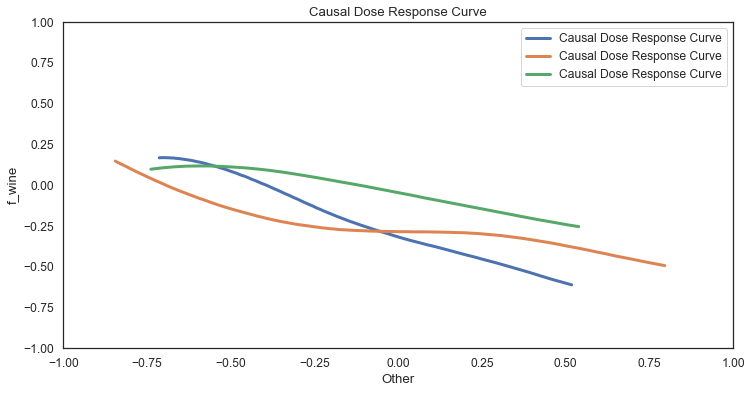

In [110]:
ind = 82
gps_res = list_gps_df[ind]

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_res['Treatment'], gps_res['Causal_Dose_Response'], 
         label='Causal Dose Response Curve', linewidth=3)
#plt.plot(gps_res['Treatment'], gps_res['Lower_CI'], 'k--', label='95% confidence interval')
#plt.plot(gps_res['Treatment'], gps_res['Upper_CI'], 'k--')

ind = 83
gps_res = list_gps_df[ind]
plt.plot(gps_res['Treatment'], gps_res['Causal_Dose_Response'], 
         label='Causal Dose Response Curve', linewidth=3)
#plt.plot(gps_res['Treatment'], gps_res['Lower_CI'], 'k--', label='95% confidence interval')
#plt.plot(gps_res['Treatment'], gps_res['Upper_CI'], 'k--')

ind = 84
gps_res = list_gps_df[ind]
plt.plot(gps_res['Treatment'], gps_res['Causal_Dose_Response'], 
         label='Causal Dose Response Curve', linewidth=3)
#plt.plot(gps_res['Treatment'], gps_res['Lower_CI'], 'k--', label='95% confidence interval')
#plt.plot(gps_res['Treatment'], gps_res['Upper_CI'], 'k--')

plt.ylim(-1,1)
plt.xlim(-1,1)
ax.legend()
plt.title('Causal Dose Response Curve')
plt.xlabel(res_df['treat'][ind])
plt.ylabel(res_df['out'][ind])
plt.show()